In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.utils import resample
from sklearn.utils import shuffle
import shutil
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# we added the separation and header because the data is not organized, one can run without sep and header
#to understand the difference

train_df = pd.read_csv('./train.txt', sep=" ", header=None)

#Columns are added because it was seen that column names were 0,1,2,3, so new column names are added
#which are given in descriptions
train_df.columns=['patient id', 'filename', 'class', 'data source']

# Since we are doing image classification, patient id and data source is of no importance to us, so
#we can drop them
train_df=train_df.drop(['patient id', 'data source'], axis=1 )

In [330]:
#same as train
test_df = pd.read_csv('./test.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [197]:
test_df.head()#see the first 5 columns for test

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [198]:
train_path = 'C:/Users/abduv/Downloads/covid19_data/train/'  #directory path
test_path = 'C:/Users/abduv/Downloads/covid19_data/test/'

In [199]:
train_df['class'].value_counts()

positive    15994
negative    13992
Name: class, dtype: int64

In [200]:
negative  = train_df[train_df['class']=='negative']   #negative values in class column
positive = train_df[train_df['class']=='positive']  #positive values in class column

#majority class that  is negative, we need to downsample/decrease that class so that there is no bias
#n_samples = 10000 means we want 10000 sample of class negative, since there are 10000 samples of class positive
df_majority_downsampled_neg = resample(negative, replace = True, n_samples = 10000)
df_majority_downsampled_pos = resample(positive, replace = True, n_samples = 10000)
#concatenate
train_df = pd.concat([df_majority_downsampled_pos, df_majority_downsampled_neg])

train_df = shuffle(train_df) # shuffling so that there is particular sequence

In [201]:
train_df['class'].value_counts()

positive    10000
negative    10000
Name: class, dtype: int64

In [202]:
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=0)

In [203]:
#Let's see how many images for training and validation and testing
print(f"Negative and positive values of train: {train_df['class'].value_counts()}")
print(f"Negative and positive values of validation: {valid_df['class'].value_counts()}")
print(f"Negative and positive values of test: {test_df['class'].value_counts()}")

Negative and positive values of train: positive    8040
negative    7960
Name: class, dtype: int64
Negative and positive values of validation: negative    2040
positive    1960
Name: class, dtype: int64
Negative and positive values of test: positive    200
negative    200
Name: class, dtype: int64


In [204]:
#Let's start the modelling task
#ImageDataGenerator lets you augment your images in real-time while your model is still training! 
#You can apply any random transformations on each training image as it is passed to the model. 
#This will not only make your model robust but will also save up on the overhead memory!


#We will apply the Image Data Generator on training with various parameters, but we won't apply 
#the same parameters on testin. Why?
# Because we want the test iamges as it is, we don't want biasedness,
#also if we fit it we will be applying
# the model only on these test images only, it can't predict new images if fed into model
#Because new images will not be augmented this way


train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_df, directory=train_path, x_col='filename', 
                                              y_col='class', target_size=(200,200), batch_size=64, 
                                               class_mode='binary')
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_df, directory=train_path, x_col='filename',
                                             y_col='class', target_size=(200,200), batch_size=64, 
                                            class_mode='binary')
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_path, x_col='filename', 
                                            y_col='class', target_size=(200,200), batch_size=64,
                                             class_mode='binary')
#class mode binary because we want the classifier to predict covid or not
#target size (200,200) means we want the images to resized to 200*200

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [205]:
import tensorflow as tf
#Our base model is InceptionResNetV2, new readers are encouraged to see the architecture of this particular model

base_model = tf.keras.applications.DenseNet201(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
for layer in base_model.layers:
    layer.trainable = False

In [206]:
#Now we will add some more layers to the base model for our requirements

model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("ResNet50V2.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [207]:
history = model.fit(train_gen, 
                    validation_data=valid_gen, epochs=20, 
                    callbacks=[callbacks])

Epoch 1/20
250/250 [==============================] - 1259s 5s/step - loss: 0.2790 - accuracy: 0.8864 - val_loss: 0.3468 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 1308s 5s/step - loss: 0.2371 - accuracy: 0.9048 - val_loss: 0.4943 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 1130s 5s/step - loss: 0.2245 - accuracy: 0.9104 - val_loss: 0.3209 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 1095s 4s/step - loss: 0.2201 - accuracy: 0.9139 - val_loss: 0.2744 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 1076s 4s/step - loss: 0.2097 - accuracy: 0.9144 - val_loss: 0.1955 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 6/20
250/250 [==============================] - 1116s 4s/step - loss: 0.2135 - accuracy: 0.9157 - val_loss: 0.3161 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 7/20
250/250 [==============================] - ETA:

In [208]:
model.load_weights('./ResNet50V2.h5')
model.evaluate(test_gen)

7/7 [==============================] - 34s 5s/step - loss: 0.2457 - accuracy: 0.8875


[0.2456853985786438, 0.887499988079071]

In [46]:
os.path.dirname(train_path)

'C:/Users/abduv/Downloads/covid19_data/train'

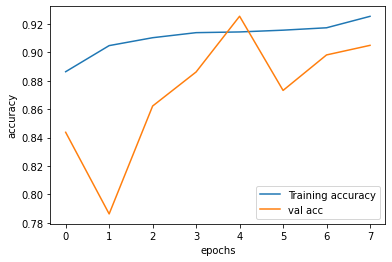

In [209]:
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'], label="val acc")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

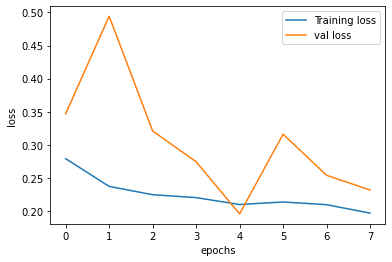

In [210]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'], label="val loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [236]:
image = load_img( test_path+'MIDRC-RICORD-1C-SITE2-000098-66227-0.png',target_size=(200,200,3))
img= np.array(image)
img = img.reshape(1,200,200,3)
label = model.predict(img)
result = np.argmax(label, axis=1)
# result3 = (model.predict(img) > 0.00005 ? 1 : 0).astype("int32")
if (model.predict(img) > 0.001):
    result3 = 1 
else: result3 = 0
print(f"argmax: {result}")
print(f"origin: {label}")
print(f"grt 0.5: {result3}")

1/1 [==============================] - 0s 118ms/step
argmax: [0]
origin: [[0.03353984]]
grt 0.5: 1


In [212]:
train_gen.class_indices

{'negative': 0, 'positive': 1}

In [233]:
test_df.sample(3)

,filename,class
11,MIDRC-RICORD-1C-419639-000025-50888-0.png,positive
232,bb068d57-86a8-4347-bee0-e29d59ddef6b.png,negative
145,MIDRC-RICORD-1C-SITE2-000098-66227-0.png,positive


In [237]:
# DENSENET201

pretrained_densenet = tf.keras.applications.DenseNet201(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)

for layer in pretrained_densenet.layers:
    layer.trainable = False

In [238]:
model2 = tf.keras.Sequential([
    pretrained_densenet, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("DenseNet201.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model2.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [239]:
history2 = model2.fit(train_gen, 
                    validation_data=valid_gen, epochs=20, 
                    callbacks=[callbacks])

Epoch 1/20
250/250 [==============================] - 1089s 4s/step - loss: 0.2776 - accuracy: 0.8886 - val_loss: 0.4189 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 1071s 4s/step - loss: 0.2365 - accuracy: 0.9043 - val_loss: 0.2816 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 1098s 4s/step - loss: 0.2256 - accuracy: 0.9077 - val_loss: 0.2521 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 1067s 4s/step - loss: 0.2138 - accuracy: 0.9160 - val_loss: 0.2232 - val_accuracy: 0.9128 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 1154s 5s/step - loss: 0.2083 - accuracy: 0.9177 - val_loss: 0.3050 - val_accuracy: 0.8658 - lr: 0.0010
Epoch 6/20
250/250 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9197
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
250/250 [==============================] - 

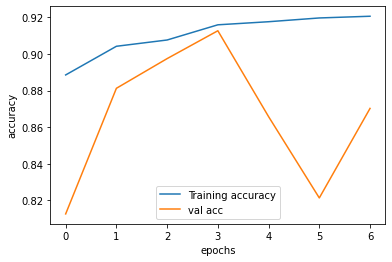

In [240]:
plt.plot(history2.history['accuracy'],label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label="val acc")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

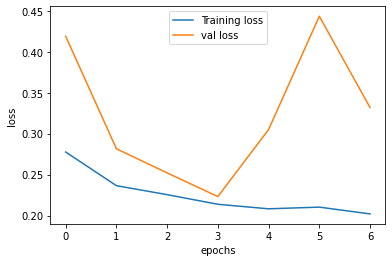

In [241]:
plt.plot(history2.history['loss'],label='Training loss')
plt.plot(history2.history['val_loss'], label="val loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [242]:
model2.load_weights('./DenseNet201.h5')
model2.evaluate(test_gen)

7/7 [==============================] - 34s 5s/step - loss: 0.3822 - accuracy: 0.8225


[0.3822437524795532, 0.8224999904632568]

In [266]:
from tensorflow.keras.preprocessing.image import load_img
image = load_img( test_path+'MIDRC-RICORD-1C-419639-000025-39552-1.png',target_size=(200,200,3))
img= np.array(image)
img = img.reshape(1,200,200,3)
label = model2.predict(img)
result = np.argmax(label, axis=1)
result3 = (model2.predict(img) > 0.5).astype("int32")
print(f"argmax: {result}")
print(f"origin: {label}")
print(f"grt 0.5: {result3}")

1/1 [==============================] - 0s 126ms/step
argmax: [0]
origin: [[0.99888647]]
grt 0.5: [[1]]


In [264]:
test_df.sample(3)

,filename,class
325,ac648f87-a79f-4ce0-9439-23a8dd886b71.png,negative
41,MIDRC-RICORD-1C-419639-001735-74702-0.png,positive
112,MIDRC-RICORD-1C-419639-000025-39552-1.png,positive


In [267]:
#VGG

pretrained_vgg = tf.keras.applications.VGG16(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)

for layer in pretrained_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [268]:
#VGG
#Now we will add some more layers to the base model for our requirements

model3 = tf.keras.Sequential([
    pretrained_vgg, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("vggClassifier.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model3.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [269]:
history3 = model3.fit(train_gen, 
                    validation_data=valid_gen, epochs=20, 
                    callbacks=[callbacks])

Epoch 1/20
250/250 [==============================] - 1121s 4s/step - loss: 0.3376 - accuracy: 0.8505 - val_loss: 0.3484 - val_accuracy: 0.8555 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - 1081s 4s/step - loss: 0.2968 - accuracy: 0.8754 - val_loss: 0.2957 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - 1080s 4s/step - loss: 0.2955 - accuracy: 0.8737 - val_loss: 0.2216 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - 1076s 4s/step - loss: 0.2884 - accuracy: 0.8789 - val_loss: 0.2159 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 5/20
250/250 [==============================] - 1079s 4s/step - loss: 0.2863 - accuracy: 0.8818 - val_loss: 0.2137 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 6/20
250/250 [==============================] - 1076s 4s/step - loss: 0.2795 - accuracy: 0.8813 - val_loss: 0.4654 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 7/20
250/250 [==============================] - ETA:

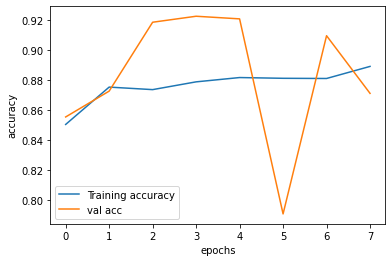

In [270]:
plt.plot(history3.history['accuracy'],label='Training accuracy')
plt.plot(history3.history['val_accuracy'], label="val acc")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

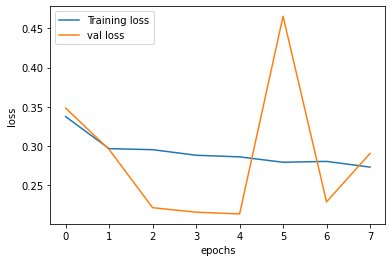

In [271]:
plt.plot(history3.history['loss'],label='Training loss')
plt.plot(history3.history['val_loss'], label="val loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [273]:
model3.load_weights('./vggClassifier.h5')
model3.evaluate(test_gen)

7/7 [==============================] - 37s 5s/step - loss: 0.3277 - accuracy: 0.8675


[0.32773643732070923, 0.8675000071525574]

In [327]:
from tensorflow.keras.preprocessing.image import load_img
image = load_img( train_path+'MIDRC-RICORD-1C-440808-000018-8.403-0.png',target_size=(200,200,3))
img= np.array(image)
img = img.reshape(1,200,200,3)
label = model3.predict(img)
result = np.argmax(label, axis=1)
result3 = (model3.predict(img) > 0.5).astype("int32")
print(f"argmax: {result}")
print(f"origin: {label}")
print(f"grt 0.5: {result3}")

1/1 [==============================] - 0s 79ms/step
argmax: [0]
origin: [[0.]]
grt 0.5: [[0]]


In [326]:
train_df.sample(5)

,filename,class
2398,MIDRC-RICORD-1C-440808-000018-8.403-0.png,positive
10971,1b4ccf65-5872-4694-b441-599471b7794a.png,negative
13464,a2018dbd-1979-452a-a629-b5230b69d259.png,negative
227,616f829f195d0cd856616586c7c35e_jumbo.jpeg,negative
23541,A389295-12-26-1900-NA-CHEST_AP_PORT-41358-3.00...,positive
